# FPA - When to publish on twitter in Mexico

This Jupyter Notebook process the 11,781 tweets from 230 users to detect if there is a moment of the day which could provide more advantage to receive a better engagment. 

Team members:
- José Manuel Tapia Avitia      A00834191
- Carloz Alonzo López Castañeda A01378902

## Introduction

### Modules

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
import scipy

import datetime
import warnings
warnings.filterwarnings("ignore")

### Data exploration

In [2]:
data = pd.read_csv("datasets/tweets_users.csv")
data.drop(columns=['Unnamed: 0'], inplace=True)
print('Shape of the dataframe:', data.shape)
print('Number of usernames:', data['username'].nunique())
print('Columns of the dataframe:', data.columns)
data.head()

Shape of the dataframe: (11781, 14)
Number of usernames: 230
Columns of the dataframe: Index(['username', 'created_at', 'verified', 'followers_count', 'date',
       'timezone', 'tweet', 'nlikes', 'nreplies', 'nretweets', 'lang',
       'sentiment', 'emotion', 'hate_speech'],
      dtype='object')


,username,created_at,verified,followers_count,date,timezone,tweet,nlikes,nreplies,nretweets,lang,sentiment,emotion,hate_speech
0,9059,1.648233e+12,False,83739,2022-03-25 12:33:52,-600,"El presidente brasileño, Jair Bolsonaro, firmó...",0,0,0,es,NEU,others,['NEU']
1,9059,1.648233e+12,False,83739,2022-03-25 12:23:44,-600,Nada justifica la violencia. Fomentemos valore...,0,0,0,es,NEU,others,['NEU']
2,9059,1.648187e+12,False,83739,2022-03-24 23:46:18,-600,El presidente AMLO pide una disculpa a la gobe...,1,0,0,es,NEG,others,['NEU']
3,9059,1.648186e+12,False,83739,2022-03-24 23:25:03,-600,Trump demanda a Hillary Clinton y al Comité Na...,1,0,0,es,NEU,others,['NEU']
4,9059,1.648186e+12,False,83739,2022-03-24 23:23:47,-600,Video: url,1,0,0,en,NEU,others,['NEU']


In [3]:
# Count number of tweets per user
data['username'].value_counts(dropna=False)

3950     634
13182    619
12985    614
12880    494
4295     425
        ... 
6840       1
5526       1
4731       1
6062       1
7291       1
Name: username, Length: 230, dtype: int64

From the 230 users, 80 of them have less than 10 tweets

In [4]:
limit_tweets = 10
print('There is', 
      len([A for A in (data['username'].value_counts() < limit_tweets) if A]),
      'people with less than', limit_tweets, 'tweets')

There is 80 people with less than 10 tweets


## Exploratory Data Analysis

### Distribution of people according to their number of tweets

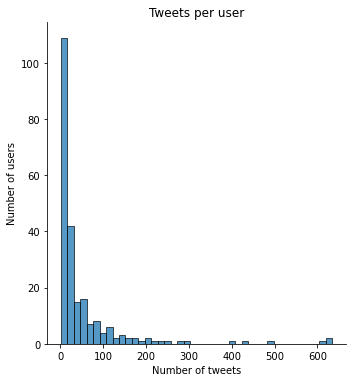

In [5]:
ax = sns.displot(data['username'].value_counts(dropna=False).tolist())
plt.title('Tweets per user')
plt.xlabel('Number of tweets')
plt.ylabel('Number of users')
plt.savefig('figures/tweets_per_user.png')
plt.show()

### Sentiments and emotions on tweets

Count number of tweets with positive, neutral, or negative sentiments.

In [6]:
data['sentiment'].value_counts(dropna=False)

NEU    5651
NEG    4474
POS    1656
Name: sentiment, dtype: int64

Count number of tweets with each type of emotion considered.

In [7]:
data['emotion'].value_counts(dropna=False)

others      7545
anger       1985
joy         1797
sadness      282
surprise      75
disgust       74
fear          23
Name: emotion, dtype: int64

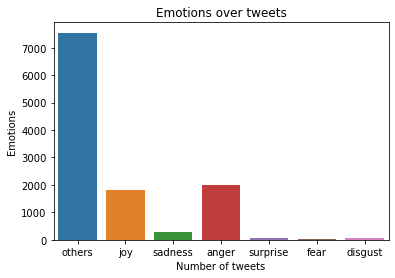

In [8]:
ax = sns.countplot(data=data, x='emotion')
plt.title('Emotions over tweets')
plt.xlabel('Number of tweets')
plt.ylabel('Emotions')
plt.savefig('figures/all_emotions.png')
plt.show()

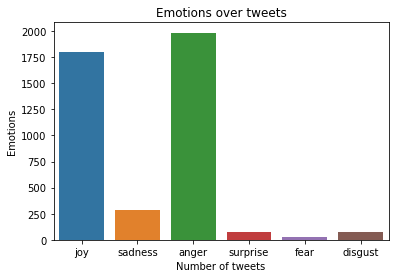

In [9]:
ax = sns.countplot(data=data[data['emotion']!='others'], x='emotion')
plt.title('Emotions over tweets')
plt.xlabel('Number of tweets')
plt.ylabel('Emotions')
plt.savefig('figures/emotions_without_others.png')
plt.show()

In [10]:
data['lang'].value_counts(dropna=False)

es    11304
en      477
Name: lang, dtype: int64

In [11]:
data['hate_speech'].value_counts(dropna=False)

['NEU']                                  11116
['hateful']                                358
['hateful', 'targeted', 'aggressive']      188
['hateful', 'aggressive']                   80
['hateful', 'targeted']                     31
['targeted']                                 8
Name: hate_speech, dtype: int64

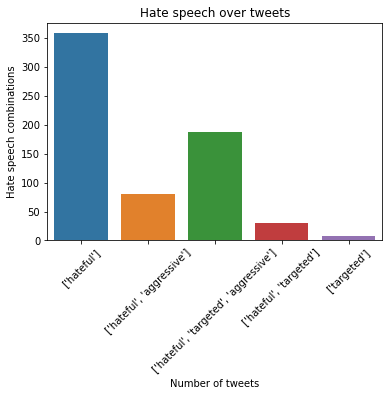

In [12]:
ax = sns.countplot(data=data[data['hate_speech']!="['NEU']"], x='hate_speech')
plt.title('Hate speech over tweets')
plt.xlabel('Number of tweets')
plt.xticks(rotation = 45)
plt.ylabel('Hate speech combinations')
plt.savefig('figures/hate_speech_tweets.png', bbox_inches='tight')
plt.show()

### Correlation

Parse data for EDA

In [13]:
# Encoding setiment to {"Positive": 1, "Negative": -1, "Neutral":0}
cleanup_nums = {'sentiment': {'POS': 1, 'NEG': -1, 'NEU': 0},'lang':{'es':0, 'en':1}}
emotion_dummies = pd.get_dummies(data.emotion, prefix='Emotion')
df = data.replace(cleanup_nums)
df = pd.concat([df, emotion_dummies], axis=1)

def parse_date(date_str, info):
  date_parsed = datetime.datetime.fromisoformat(date_str)
  if info == 'year':
    return date_parsed.year
  elif info == 'month':
    return date_parsed.month
  elif info == 'day':
    return date_parsed.day
  elif info == 'hour':
    return date_parsed.hour
  elif info == 'minute':
    return date_parsed.minute
  elif info == 'second':
    return date_parsed.second
  elif info == 'minute_day':
    return date_parsed.hour * 60 + date_parsed.minute

day_info = ['year', 'month', 'day', 'hour', 'minute', 'second', 'minute_day']
for info in day_info:
  df[info] = df['date'].map(lambda date: parse_date(date, info))

df.describe()

,username,created_at,followers_count,timezone,nlikes,nreplies,nretweets,lang,sentiment,Emotion_anger,...,Emotion_others,Emotion_sadness,Emotion_surprise,year,month,day,hour,minute,second,minute_day
count,11781.000000,1.178100e+04,11781.000000,11781.0,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000,...,11781.000000,11781.000000,11781.000000,11781.0,11781.0,11781.000000,11781.000000,11781.000000,11781.000000,11781.000000
mean,8790.522367,1.647770e+12,4080.901367,-600.0,12.723793,0.872507,3.346320,0.040489,-0.239199,0.168492,...,0.640438,0.023937,0.006366,2022.0,3.0,19.563535,13.750955,29.431882,28.992700,854.489177
std,4912.376783,3.458412e+08,8501.375399,0.0,304.441226,14.138811,80.385259,0.197111,0.680553,0.374318,...,0.479892,0.152859,0.079537,0.0,0.0,4.011123,5.844151,17.615032,17.577622,350.963383
min,53.000000,1.646464e+12,401.000000,-600.0,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,2022.0,3.0,5.000000,0.000000,0.000000,0.000000,0.000000
25%,4295.000000,1.647571e+12,594.000000,-600.0,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,...,0.000000,0.000000,0.000000,2022.0,3.0,17.000000,10.000000,14.000000,14.000000,612.000000
50%,9059.000000,1.647834e+12,1371.000000,-600.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,2022.0,3.0,20.000000,14.000000,30.000000,29.000000,857.000000
75%,12985.000000,1.648050e+12,4605.000000,-600.0,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,2022.0,3.0,23.000000,19.000000,45.000000,44.000000,1146.000000
max,16434.000000,1.648237e+12,83739.000000,-600.0,24257.000000,1027.000000,5991.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,2022.0,3.0,25.000000,23.000000,59.000000,59.000000,1439.000000


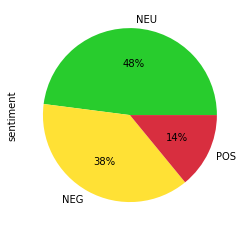

In [14]:
# Mapping back to descriptive sentiment for better interpretation
data['sentiment'] = data['sentiment']

# Plotting Sentiment proportions
data.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["#28cc2d", "#ffe135", "#d82e3f"])
plt.savefig('figures/sentiments_tweets.png')
plt.show()

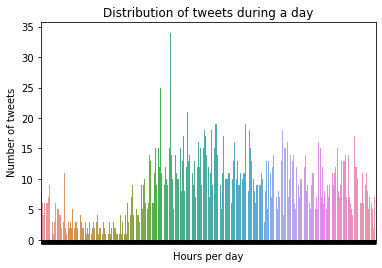

In [15]:
ax = sns.countplot(data=df, x='minute_day')
plt.title('Distribution of tweets during a day')
plt.ylabel('Number of tweets')
ax.set(xticklabels=[])
plt.xticks(rotation = 45)
plt.xlabel('Hours per day')
plt.savefig('figures/tweets_per_day.png', bbox_inches='tight')
plt.show()

In [16]:
list(set(df.dtypes.tolist()))
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,username,created_at,followers_count,timezone,nlikes,nreplies,nretweets,lang,sentiment,year,month,day,hour,minute,second,minute_day
0,9059,1.648233e+12,83739,-600,0,0,0,0,0,2022,3,25,12,33,52,753
1,9059,1.648233e+12,83739,-600,0,0,0,0,0,2022,3,25,12,23,44,743
2,9059,1.648187e+12,83739,-600,1,0,0,0,-1,2022,3,24,23,46,18,1426
3,9059,1.648186e+12,83739,-600,1,0,0,0,0,2022,3,24,23,25,3,1405
4,9059,1.648186e+12,83739,-600,1,0,0,1,0,2022,3,24,23,23,47,1403


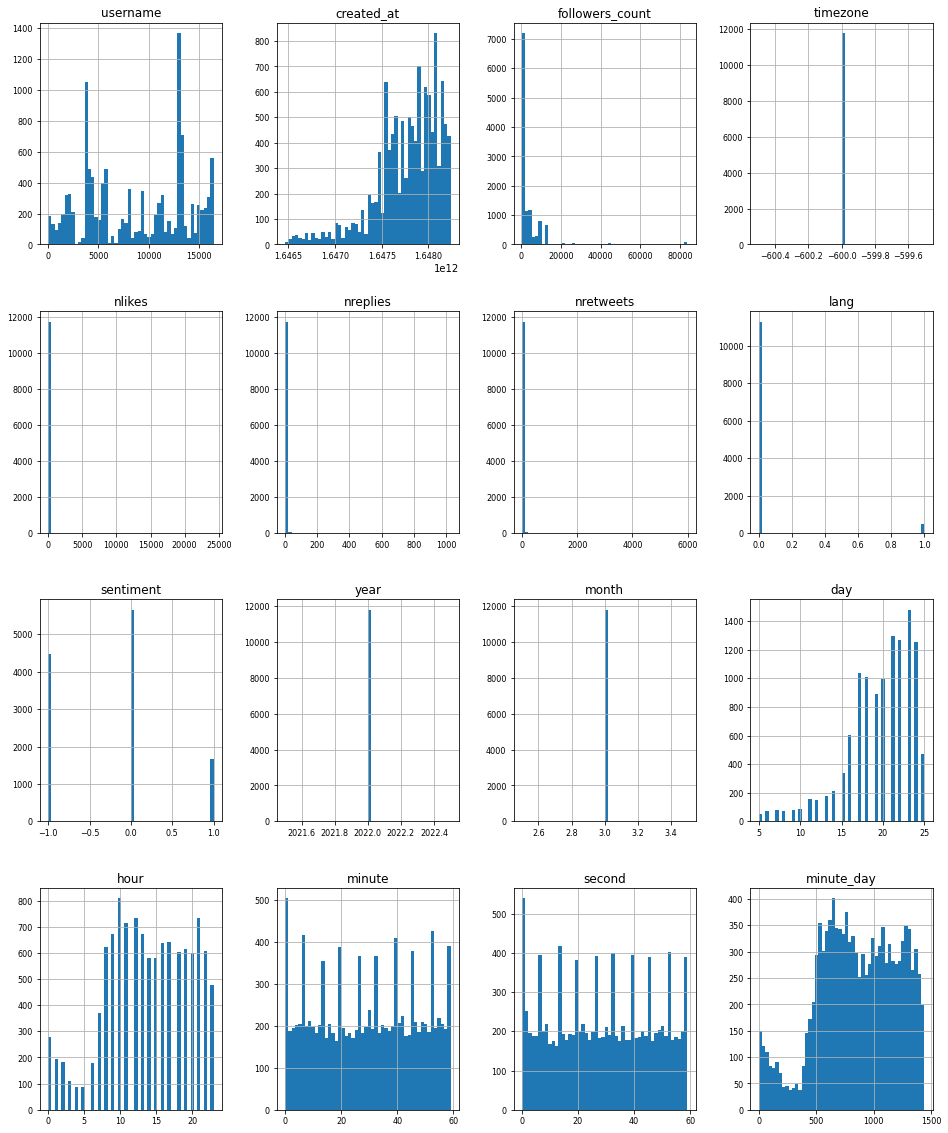

In [17]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8); # 
plt.savefig('figures/dist_all.svg')
plt.show()

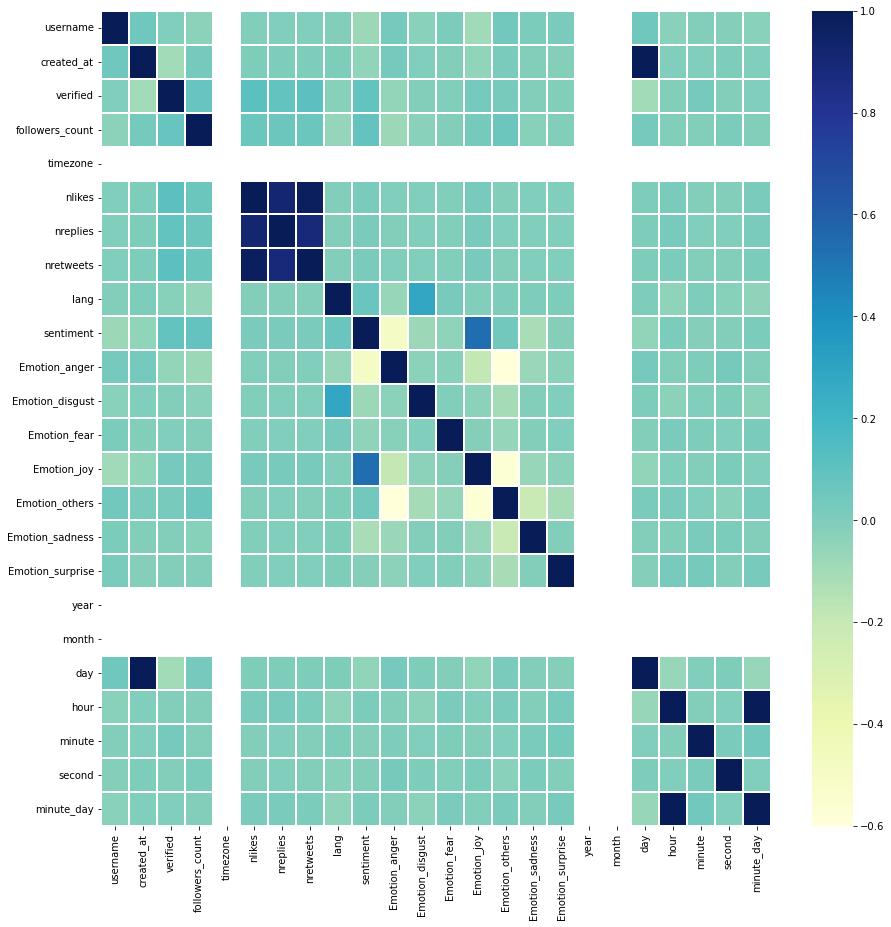

In [18]:
corrmat = df.corr()

f, ax = plt.subplots(figsize =(15, 15))
sns.heatmap(corrmat, ax = ax, cmap ="YlGnBu", linewidths = 0.1)
plt.savefig('figures/corr_matrix.png')
plt.show()

## Deep analysis of time

Group tweets to analyze them together. Notice that our function to retrieve the weekday from the date only works on this case because it match perfectly. For further usercases is necessary a roughly method.

In [19]:
# Retrieve weekday from date
week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['weekday'] = df['day'].map(lambda w: week[w%7])
# Group tweets in group of three hours
group_size = 3
df['group_hours'] = df['hour'].map(lambda w: w//group_size)

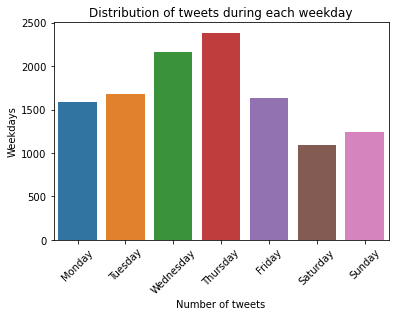

In [20]:
sns.countplot(data=df, x='weekday', order=week)
plt.title('Distribution of tweets during each weekday')
plt.xlabel('Number of tweets')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.ylabel('Weekdays')
plt.savefig('figures/weekdays_dist.png', bbox_inches='tight')
plt.show()

### Example of users activity

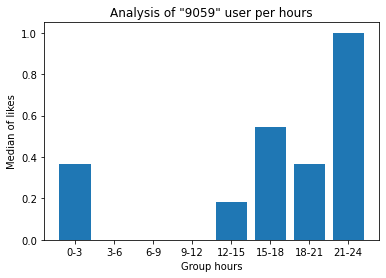

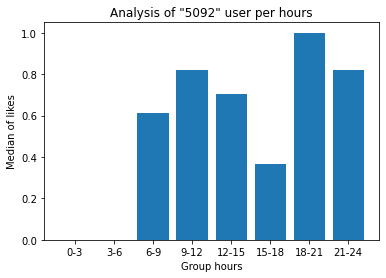

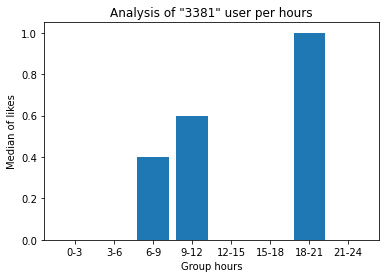

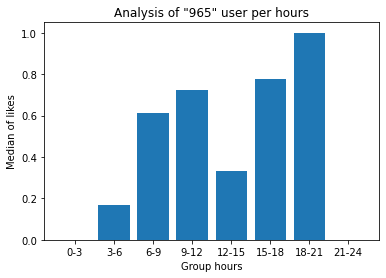

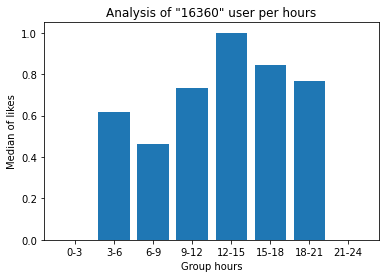

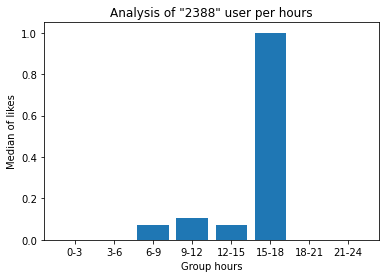

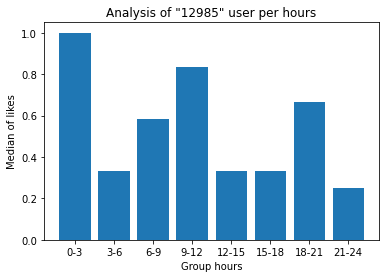

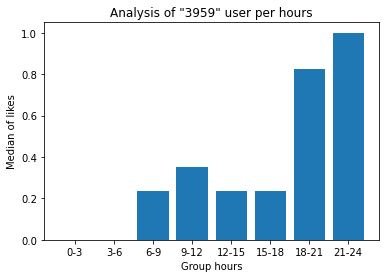

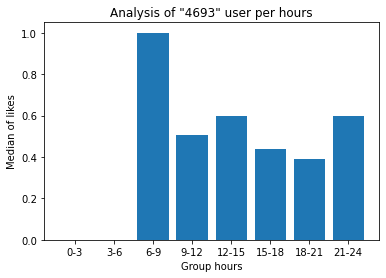

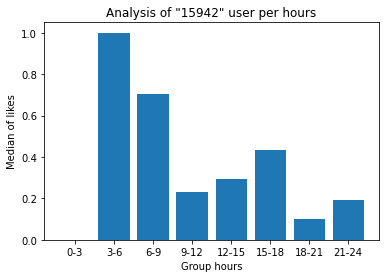

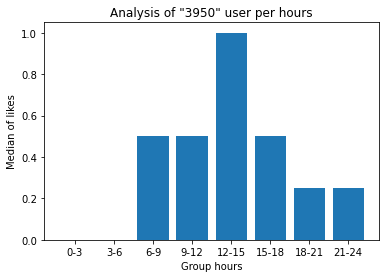

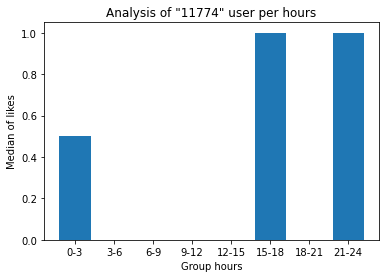

In [21]:
users = df['username'].unique()
for user in users[:20]:
  df_user = df[df['username'] == user]
  if len(df_user) < 20:
    continue

  group_hours = range(24//group_size)
  prev = 0
  group_names = []
  for group in group_hours:
    group_names.append(f'{prev}-{(group+1)*group_size}')
    prev = (group+1)*group_size

  nlikes_dist = df_user.groupby('group_hours')['nlikes'].median()
  nlikes_group = []
  for group in group_hours:
    if group in nlikes_dist:
      nlikes_group.append(nlikes_dist[group])
    else:
      nlikes_group.append(0)
  
  max_num = np.max(nlikes_group)
  if max_num > 0:
    nlikes_group = nlikes_group / max_num
    
  df_group = pd.DataFrame({"nlikes":nlikes_group}, index = group_hours)
  plt.bar(group_names, nlikes_group)
  plt.title(f'Analysis of "{user}" user per hours')
  plt.ylabel('Median of likes')
  plt.xlabel('Group hours')
  plt.savefig(f'figures/user{user}_norm.png')
  plt.show()

### General functions to do analysis per hour and weekday

In [22]:
def analysis_per_grouphour(filter_sentiment=None, figure_name='grouphours_users', filter_day=None, show_figure=True, savefig=True):

  group_lists = [[] for _ in range(24//group_size)]

  for user in users:
    df_user = df[df['username'] == user]
    if filter_sentiment is not None:
      df_user = df_user[df_user['sentiment'] == filter_sentiment]
    if filter_day is not None:
      df_user = df_user[df_user['weekday'] == filter_day]
      
    group_hours = range(24//group_size)
    prev = 0
    group_names = []
    for group in group_hours:
      group_names.append(f'{prev}-{(group+1)*group_size}')
      prev = (group+1)*group_size

    nlikes_dist = df_user.groupby('group_hours')['nlikes'].median()
    nlikes_group = []
    for group in group_hours:
      if group in nlikes_dist:
        nlikes_group.append(nlikes_dist[group])
      else:
        nlikes_group.append(0)
    max_num = np.max(nlikes_group)
    if max_num > 0:
      nlikes_group = nlikes_group / max_num

    for i in group_hours:
      group_lists[i].append(nlikes_group[i])


  poderoso_group = [np.mean(group_lists[i]) for i in group_hours]
  if show_figure:
    sns.barplot(group_names, poderoso_group, palette='Set1')
    if filter_sentiment is None:
      if filter_day is None:
        title = 'Analysis of tweets per hours'
      else:
        title = 'Analysis of tweets per hours on ' + filter_day
    else:
      title = f'Analysis of {"positive" if filter_sentiment == 1 else "negative"} tweets per hour'
    plt.title(title)
    plt.xticks(rotation = 45)
    plt.ylabel('Importance percentage')
    plt.xlabel('Group hours')
    if savefig:
      plt.savefig(f'figures/{figure_name}.png', bbox_inches='tight')
    plt.show()
  return group_lists

In [23]:
def analysis_per_weekday(filter_sentiment=None, figure_name='weekdays_users', show_figure=True, savefig=True):
  group_lists = [[] for _ in week]

  for user in users:
    df_user = df[df['username'] == user]
    if filter_sentiment is not None:
      df_user = df_user[df_user['sentiment'] == filter_sentiment]
    nlikes_dist = df_user.groupby('weekday')['nlikes'].median()
    nlikes_group = []
    for group in week:
      if group in nlikes_dist:
        nlikes_group.append(nlikes_dist[group])
      else:
        nlikes_group.append(0)
    max_num = np.max(nlikes_group)
    if max_num > 0:
      nlikes_group = nlikes_group / max_num

    for i, _ in enumerate(week):
      group_lists[i].append(nlikes_group[i])


  poderoso_group = [np.mean(group_lists[i]) for i, _ in enumerate(week)]
  if show_figure:
    sns.barplot(week, poderoso_group, palette='Set1')
    if filter_sentiment is None:
      title = 'Analysis of tweets per weekdays'
    else:
      title = f'Analysis of {"positive" if filter_sentiment == 1 else "negative"} tweets per weekdays'
    plt.title(title)
    plt.xticks(rotation = 45)
    plt.ylabel('Importance percentage')
    plt.xlabel('Weekdays')
    if savefig:
      plt.savefig(f'figures/{figure_name}.png', bbox_inches='tight')
    plt.show()
  return group_lists

### General analysis per hour

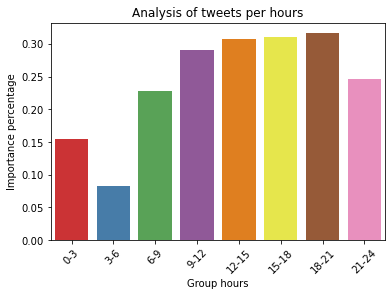

In [24]:
group = analysis_per_grouphour(figure_name='grouphours_users')

### Analysis of positive tweets per group of hours

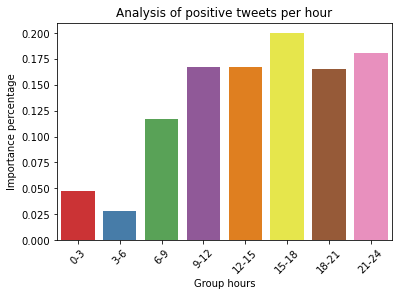

In [25]:
group = analysis_per_grouphour(filter_sentiment=1, figure_name='positive_tweets_hours')

### Analysis of negative tweets per group of hours

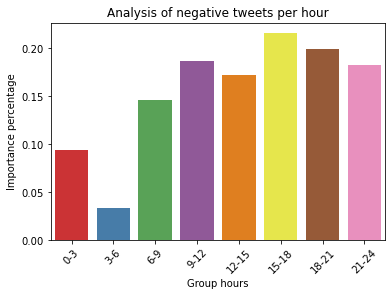

In [26]:
group = analysis_per_grouphour(filter_sentiment=-1, figure_name='negative_tweets_hours')

### General analysis per weekday

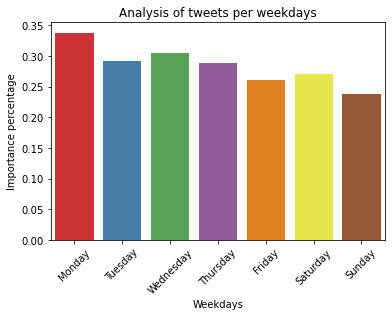

In [27]:
group = analysis_per_weekday(figure_name='weekdays_users')

### Analysis per weekday (Positive)

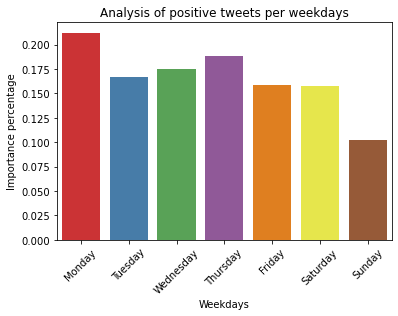

In [28]:
group = analysis_per_weekday(filter_sentiment=1, figure_name='positive_tweets_week')

### Analysis per weekday (Negative)

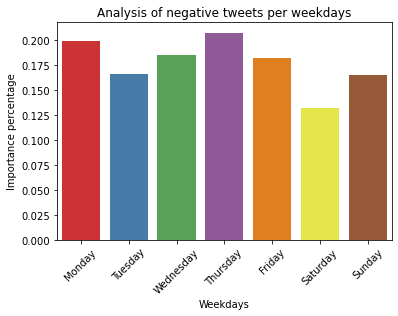

In [29]:
group = analysis_per_weekday(filter_sentiment=-1, figure_name='negative_tweets_week')

## Statistics

### Group of hours

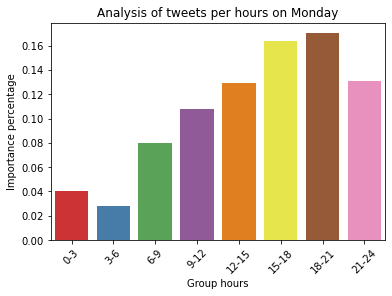

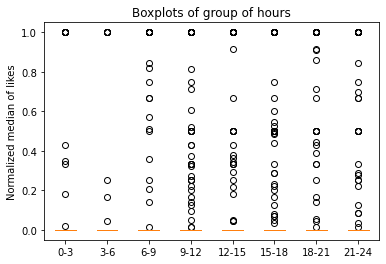

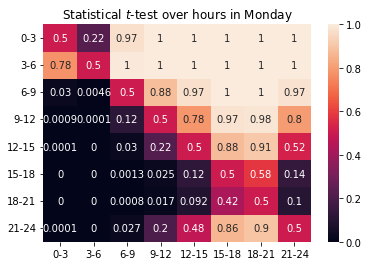

In [30]:
# General / hour for thursday
group_lists = analysis_per_grouphour(figure_name='monday_tweets_hours',
                                     show_figure=True,
                                     filter_day='Monday',
                                     savefig=True)

# Boxplot
plt.boxplot(group_lists)
plt.title('Boxplots of group of hours')
group_hours = range(24//group_size)
prev = 0
group_names = []
for group in group_hours:
  group_names.append(f'{prev}-{(group+1)*group_size}')
  prev = (group+1)*group_size

plt.xticks(range(1, 24//group_size+1), group_names)
plt.ylabel('Normalized median of likes')
plt.savefig('figures/boxplots_hours.png')
plt.show()

# Heat map
df_comparison = dict()
for hour, a_group in enumerate(group_names):
  df_comparison[a_group] = []
  for hour2, b_group in enumerate(group_names):
    _, p_value = scipy.stats.ttest_ind(group_lists[hour], group_lists[hour2], alternative='less')
    df_comparison[a_group].append(round(p_value, 4))

df_comparison = pd.DataFrame(df_comparison, index=group_names)
sns.heatmap(df_comparison, vmin=0, vmax=1, annot=True)
plt.title('Statistical $t$-test over hours in Monday')
plt.savefig('figures/heatmap_monday.png',  bbox_inches='tight')
plt.show()



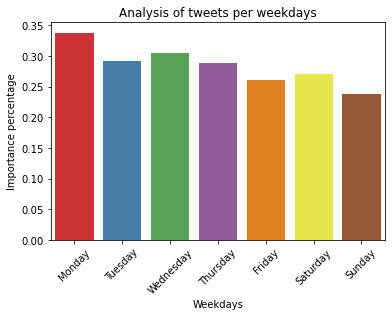

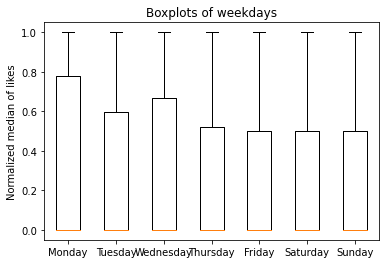

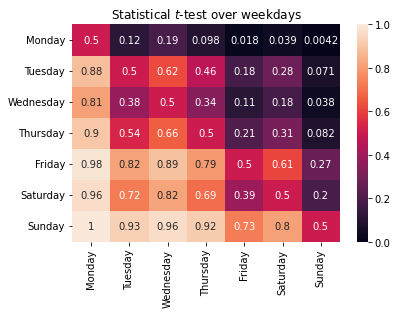

In [31]:
# General / week
group_lists = analysis_per_weekday(show_figure=True)

# Boxplot
plt.boxplot(group_lists)
plt.title('Boxplots of weekdays')
plt.xticks(range(1, 8), week)
plt.ylabel('Normalized median of likes')
plt.savefig('figures/boxplots_weekdays.png')
plt.show()

# Heat map
df_comparison = dict()
for weekday, a_group in enumerate(week):
  df_comparison[a_group] = []
  for weekday2, b_group in enumerate(week):
    _, p_value = scipy.stats.ttest_ind(group_lists[weekday], group_lists[weekday2], alternative='less')
    df_comparison[a_group].append(round(p_value, 4))

df_comparison = pd.DataFrame(df_comparison, index=week)
sns.heatmap(df_comparison, vmin=0, vmax=1, annot=True)
plt.title('Statistical $t$-test over weekdays')
plt.savefig('figures/heatmap_weekdays.png', bbox_inches='tight')
plt.show()
